In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings

# hide warnings
warnings.filterwarnings("ignore")

In [ ]:
from sktime.datasets._single_problem_loaders import load_m5

extract_path = ""
dataset = load_m5(extract_path=, include_events=True, merged=True)
with open('dataset_with_events.pkl', 'wb') as file:
    pickle.dump(dataset, file)
    print("Dataset Saved")

In [ ]:
with open('dataset_with_events.pkl', 'rb') as file:
    data = pickle.load(file)
    print("Dataset Loaded")

In [ ]:
# Feature engineering
from sktime.transformations.series.lag import Lag

data['sell_price'] = data['sell_price'].fillna(0)
# data['sell_price'] = data['sell_price'].astype(float).round(2)

f=lambda x: 1 if x==7 or x==1 or x==2 else 0
data['is_high_sale_day']=data['wday'].map(f) 

f=lambda x: 1 if x==2 or x==3 or x==4 or x==5 else 0
data['is_high_sale_months']=data['month'].map(f) 

f=lambda x: 1 if x=='Christmas' else 0
data['is_christmas']=data['event_name_1'].map(f)

# lags using Lag transformer
lags = [1, 7, 14, 21, 28] 
lag_transformer = Lag(lags=lags)
# Apply the lag transformation
lag_df = lag_transformer.fit_transform(data[['sales']])
lag_df = lag_df.fillna(0)
for lag in lags:
    data[f'lag_{lag}'] = lag_df[f'lag_{lag}__sales']

# Adding window feature
window=[7,14,21,28]
for i in window:
    data['rolling_mean_'+str(i)]=data.groupby(['item_id'])['sales'].transform(lambda s: s.rolling(i).mean())

window=['rolling_mean_7','rolling_mean_14', 'rolling_mean_7' ,'rolling_mean_21', 'rolling_mean_28']
for i in window:
    data[i]=data[i].fillna(0)

# Expading mean
data['expanding_mean']=data.groupby(['id'])['sales'].transform(lambda s: s.expanding().mean())
data['expanding_mean']=data['expanding_mean'].fillna(0)

cols_to_convert = ['event_type_1', 'event_type_2']
data[cols_to_convert] = data[cols_to_convert].apply(lambda x: x.astype('category').cat.codes + 1)

data=data.drop(
    ['event_name_1','event_name_2', 'item_id','wday','month', 'wm_yr_wk','year'],
    axis = 1,
)

with open('m5_dataset.pkl', 'wb') as file:
    pickle.dump(data, file)
    print("Dataset Saved")

### with a single item

In [ ]:
with open('m5_dataset.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
    print("Dataset Loaded")

In [ ]:
final_data = loaded_data[loaded_data['id'] == 'FOODS_3_090_CA_2_validation']
cols_to_convert = ['id']
final_data[cols_to_convert] = final_data[cols_to_convert].apply(lambda x: x.astype('category').cat.codes)
final_data

id   day  sales  event_type_1  \
state_id store_id cat_id dept_id date                                          
1        2        1      3       2011-01-29  7021     1    116             0   
                                 2011-01-30  7021     2     90             0   
                                 2011-01-31  7021     3     35             0   
                                 2011-02-01  7021     4     33             0   
                                 2011-02-02  7021     5     26             0   
...                                           ...   ...    ...           ...   
                                 2016-04-20  7021  1909     40             0   
                                 2016-04-21  7021  1910     24             0   
                                 2016-04-22  7021  1911     91             0   
                                 2016-04-23  7021  1912     73             0   
                                 2016-04-24  7021  1913     60             0   

                                             event_type_2  sell_price  \
state_id store_id cat_id dept_id date                                   
1        2        1      3       2011-01-29             0    1.250000   
                                 2011-01-30             0    1.250000   
                                 2011-01-31             0    1.250000   
                                 2011-02-01             0    1.250000   
                                 2011-02-02             0    1.250000   
...                                                   ...         ...   
                                 2016-04-20             0    1.599609   
                                 2016-04-21             0    1.599609   
                                 2016-04-22             0    1.599609   
                                 2016-04-23             0    1.599609   
                                 2016-04-24             0    1.599609   

                                             is_high_sale_day  \
state_id store_id cat_id dept_id date                           
1        2        1      3       2011-01-29                 1   
                                 2011-01-30                 1   
                                 2011-01-31                 0   
                                 2011-02-01                 0   
                                 2011-02-02                 0   
...                                                       ...   
                                 2016-04-20                 0   
                                 2016-04-21                 0   
                                 2016-04-22                 1   
                                 2016-04-23                 1   
                                 2016-04-24                 1   

                                             is_high_sale_months  \
state_id store_id cat_id dept_id date                              
1        2        1      3       2011-01-29                    0   
                                 2011-01-30                    0   
                                 2011-01-31                    0   
                                 2011-02-01                    1   
                                 2011-02-02                    1   
...                                                          ...   
                                 2016-04-20                    1   
                                 2016-04-21                    1   
                                 2016-04-22                    1   
                                 2016-04-23                    1   
                                 2016-04-24                    1   

                                             is_christmas  lag_1  lag_7  \
state_id store_id cat_id dept_id date                                     
1        2        1      3       2011-01-29             0   42.0   30.0   
                                 2011-01-30             0  116.0   45.0   
                         

In [ ]:
# Splitting into Endogeneous and Exogeneous data

X =final_data.drop(columns=['day','sales'], axis=1) 
y = final_data[['sales']]

In [ ]:
# Train and Test split
from sktime.forecasting.model_selection import temporal_train_test_split

X_train, x_test, Y_train, y_test = temporal_train_test_split(X,y)

def load():
    return (y, X)

In [ ]:
from sktime.datatypes._check import check_raise

check_raise(y, mtype='pd_multiindex_hier', scitype='Hierarchical'), check_raise(X, mtype='pd_multiindex_hier', scitype='Hierarchical')

(True, True)

In [ ]:
# error terms
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError

smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")
rmse = MeanSquaredError(multioutput='raw_values', square_root=False)

In [ ]:
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

cv = ExpandingWindowSplitter(initial_window=60, step_length=24, fh=np.arange(1, 25))

benchmark = ForecastingBenchmark()
fh = list(range(1, len(y_test) + 1))
benchmark.add_estimator(NaiveForecaster(strategy='mean'))
benchmark.add_estimator(ExponentialSmoothing())
benchmark.add_estimator(AutoETS(auto=True))

benchmark.add_task(dataset_loader=load, cv_splitter=cv, scorers=[MeanAbsolutePercentageError()], task_id="M5_smape")
benchmark.run(output_file='results.txt')

In [ ]:
benchmark.run(output_file='results.txt')

validation_id              model_id  runtime_secs  \
0      M5_smape               AutoETS      4.419062   
1      M5_smape  ExponentialSmoothing      3.250205   
2      M5_smape       NaiveForecaster      2.586395   

   MeanAbsolutePercentageError_fold_0_test  \
0                                      NaN   
1                                      0.0   
2                                      0.0   

   MeanAbsolutePercentageError_fold_1_test  \
0                                      NaN   
1                                      0.0   
2                                      0.0   

   MeanAbsolutePercentageError_fold_2_test  \
0                                      NaN   
1                                      0.0   
2                                      0.0   

   MeanAbsolutePercentageError_fold_3_test  \
0                                      NaN   
1                                      0.0   
2                                      0.0   

   MeanAbsolutePercentageError_fold_4_test  \
0                                      NaN   
1                                      0.0   
2                                      0.0   

   MeanAbsolutePercentageError_fold_5_test  \
0                                      NaN   
1                                      0.0   
2                                      0.0   

   MeanAbsolutePercentageError_fold_6_test  ...  \
0                                      NaN  ...   
1                                      0.0  ...   
2                                      0.0  ...   

   MeanAbsolutePercentageError_fold_69_test  \
0                              1.317002e+15   
1                              1.317001e+15   
2                              3.739877e+14   

   MeanAbsolutePercentageError_fold_70_test  \
0                              1.205287e+15   
1                              1.205290e+15   
2                              3.853295e+14   

   MeanAbsolutePercentageError_fold_71_test  \
0                              3.773010e+14   
1                              3.773001e+14   
2                              1.315890e+14   

   MeanAbsolutePercentageError_fold_72_test  \
0                              2.236752e+15   
1                              2.236761e+15   
2                              6.790243e+14   

   MeanAbsolutePercentageError_fold_73_test  \
0                              1.705594e+15   
1                              1.705587e+15   
2                              6.917781e+14   

   MeanAbsolutePercentageError_fold_74_test  \
0                              1.262915e+15   
1                              1.262915e+15   
2                              5.629500e+14   

   MeanAbsolutePercentageError_fold_75_test  \
0                              1.467182e+15   
1                              1.467182e+15   
2                              5.738458e+14   

   MeanAbsolutePercentageError_fold_76_test  MeanAbsolutePercentageError_mean  \
0                              1.316784e+15                      1.384215e+15   
1                              1.316784e+15                      1.150518e+15   
2                              5.852608e+14                      3.875697e+14   

   MeanAbsolutePercentageError_std  
0                     1.358178e+15  
1                     1.342209e+15  
2                     3.194107e+14  

[3 rows x 82 columns]

In [ ]:
# function to plot the test data with the prediction
from sktime.utils.plotting import plot_series

def plot_pred(y_test, y_pred):
    y_test_plot = y_test.reset_index().set_index('date')
    y_test_plot = y_test_plot.drop(['state_id','store_id','cat_id','dept_id'],axis =1)
    
    y_pred_plot = y_pred.reset_index().set_index('date')
    y_pred_plot = y_pred_plot.drop(['state_id','store_id','cat_id','dept_id'],axis =1)

    plot_series(y_test_plot, y_pred_plot , labels=['test', 'prediction'])

In [ ]:
# RamdomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ForecastingGridSearchCV

regressor = RandomForestRegressor(n_estimators=100)
forecaster = make_reduction(regressor, strategy="recursive", pooling="global")
forecaster.fit(Y_train, X=X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(),
                                     pooling='global')

MeanAbsolutePercentageError
1 2 1 3                     0.626847

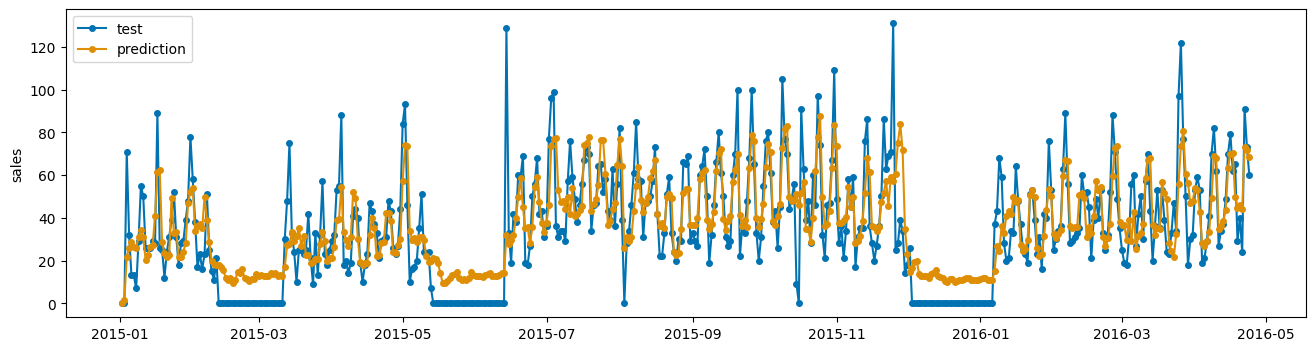

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = forecaster.predict(fh = fh, X=x_test)
plot_pred(y_test, y_pred)
smape(y_test, y_pred)

In [ ]:
from lightgbm import LGBMRegressor

regressor = LGBMRegressor(objective= 'poisson')
forecaster= make_reduction(regressor, strategy = 'recursive', pooling = 'global')

params_grid = {
    'learning_rate' : [0.4, 1, 2],
    'n_estimators' : [50, 75, 100],
}

cv = ExpandingWindowSplitter(initial_window=60, step_length=24, fh=np.arange(1, 25))

gscv = ForecastingGridSearchCV(
    forecaster, 
    cv=cv, 
    param_grid=params_grid,
)

gscv.fit(Y_train, X = X_train)
gscv.best_params_ , gscv.best_score_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 24
[LightGBM] [Info] Start training from score 3.309399
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 1424, number of used features: 24
[LightGBM] [Info] Start training from score 3.309399


({'learning_rate': 1, 'n_estimators': 100}, np.float64(4354660942956363.0))

MeanAbsolutePercentageError
1 2 1 3                     0.393839

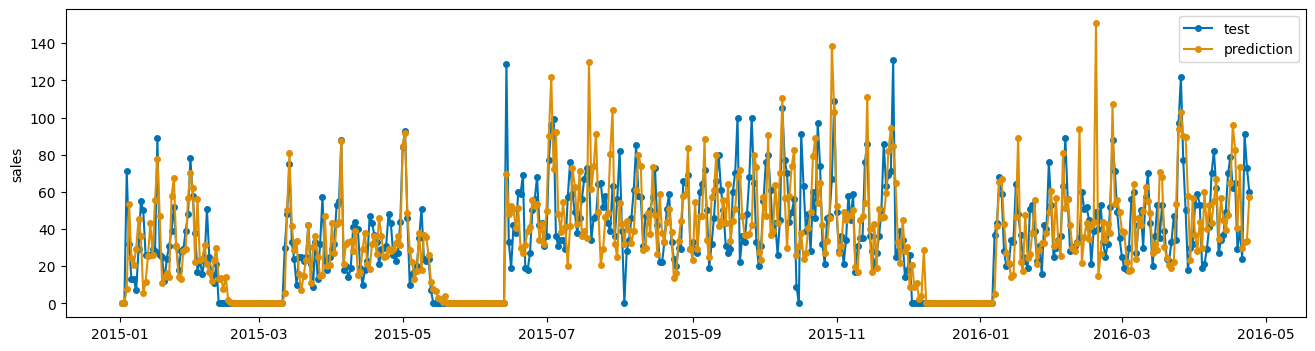

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = gscv.predict(X= x_test, fh=fh)
plot_pred(y_test, y_pred)
smape(y_test.round(), y_pred.round())

In [ ]:
# ReconcilerForecaster
from sktime.forecasting.reconcile import ReconcilerForecaster

reconciler = ReconcilerForecaster(forecaster, method = "ols")
reconciler.fit(Y_train, X=X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 2848, number of used features: 24
[LightGBM] [Info] Start training from score 3.309399


ReconcilerForecaster(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(objective='poisson'),
                                                                     pooling='global'),
                     method='ols')

MeanAbsolutePercentageError
1 2 1 3                     0.322572

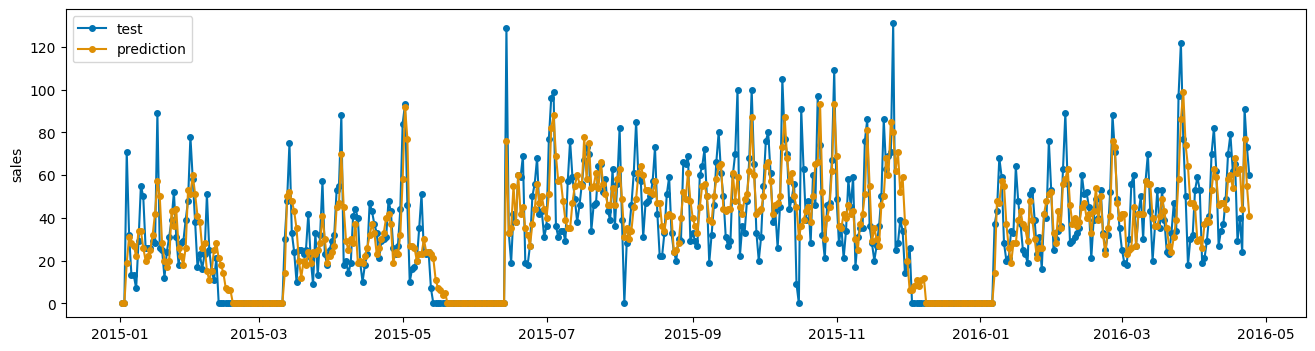

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = reconciler.predict(X= x_test, fh=fh)
plot_pred(y_test, y_pred[:479].round())
smape(y_test, y_pred[:479].round())

### with multiple items

In [ ]:
from sktime.forecasting.reconcile import ReconcilerForecaster

In [ ]:
hier_data = loaded_data[(loaded_data['id'] == 'FOODS_3_140_CA_2_validation') 
                        | (loaded_data['id'] == 'FOODS_3_090_CA_2_validation') 
                        | (loaded_data['id'] == 'HOUSEHOLD_2_512_WI_3_validation')]

# cols_to_convert = ['id']
# hier_data[cols_to_convert] = hier_data[cols_to_convert].apply(lambda x: x.astype('category').cat.codes)

hier_data.set_index('id', append=True, inplace=True)
hier_data = hier_data.reorder_levels(['state_id', 'store_id', 'cat_id', 'dept_id', 'id', 'date'])
hier_data.sort_index(inplace=True)

In [ ]:
hier_data

day  \
state_id store_id cat_id dept_id id                              date               
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29     1   
                                                                 2011-01-30     2   
                                                                 2011-01-31     3   
                                                                 2011-02-01     4   
                                                                 2011-02-02     5   
...                                                                           ...   
3        10       3      7       HOUSEHOLD_2_512_WI_3_validation 2016-04-20  1909   
                                                                 2016-04-21  1910   
                                                                 2016-04-22  1911   
                                                                 2016-04-23  1912   
                                                                 2016-04-24  1913   

                                                                             sales  \
state_id store_id cat_id dept_id id                              date                
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29    116   
                                                                 2011-01-30     90   
                                                                 2011-01-31     35   
                                                                 2011-02-01     33   
                                                                 2011-02-02     26   
...                                                                            ...   
3        10       3      7       HOUSEHOLD_2_512_WI_3_validation 2016-04-20      1   
                                                                 2016-04-21      0   
                                                                 2016-04-22      0   
                                                                 2016-04-23      0   
                                                                 2016-04-24      0   

                                                                             event_type_1  \
state_id store_id cat_id dept_id id                              date                       
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29             0   
                                                                 2011-01-30             0   
                                                                 2011-01-31             0   
                                                                 2011-02-01             0   
                                                                 2011-02-02             0   
...                                                                                   ...   
3        10       3      7       HOUSEHOLD_2_512_WI_3_validation 2016-04-20             0   
                                                                 2016-04-21             0   
                                                                 2016-04-22             0   
                                                                 2016-04-23             0   
                                                                 2016-04-24             0   

                                                                             event_type_2  \
state_id store_id cat_id dept_id id                              date                       
1        2        1      3       FOODS_3_090_CA_2_validation     2011-01-29             0   
                                                                 2011-01-30             0   
                                                                 2011-01-31             0   
                                                                 2011-02-01             0   
                                                                 2011-02-02          

In [ ]:
# Splitting into Endogeneous and Exogeneous data
X =hier_data.drop(columns=['day','sales'], axis=1) 
y = hier_data[['sales']]

# Train and Test split
X_train, x_test, Y_train, y_test = temporal_train_test_split(X,y)

In [ ]:
# ReconcilerForecaster
regressor = LGBMRegressor(n_estimators=200, learning_rate=1, objective='regression_l1')
forecaster = make_reduction(regressor, strategy='recursive', pooling='global')

reconciler = ReconcilerForecaster(forecaster, method = "bu") #bu
reconciler.fit(y=Y_train, X=X_train) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2916
[LightGBM] [Info] Number of data points in the train set: 7120, number of used features: 26
[LightGBM] [Info] Start training from score 1.000000


ReconcilerForecaster(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=1, n_estimators=200, objective='regression_l1'),
                                                                     pooling='global'),
                     method='bu')

In [ ]:
fh = list(range(1, len(y_test) + 1))
y_pred = reconciler.predict(X=x_test, fh=fh)

In [ ]:
y_pred

sales
state_id store_id cat_id  dept_id id                          date                 
1        2        1       3       FOODS_3_090_CA_2_validation 2015-01-02   0.006953
                                                              2015-01-03   0.006953
                                                              2015-01-04   6.857119
                                                              2015-01-05  30.859295
                                                              2015-01-06  28.101890
...                                                                             ...
__total  __total  __total __total __total                     2018-12-04  -0.364358
                                                              2018-12-05  -0.254460
                                                              2018-12-06  -0.675925
                                                              2018-12-07  -0.448015
                                                              2018-12-08  -0.254460

[7185 rows x 1 columns]

### Probabilistic Models on the dataset

In [ ]:
from sktime.registry import all_estimators

all_estimators(
    "forecaster",
    filter_tags={"capability:pred_int": True},
    as_dataframe=True,
    suppress_import_stdout=False,
)


name  \
0                                        ARCH   
1                                       ARIMA   
2                                   AutoARIMA   
3                                     AutoETS   
4                                        BATS   
5                           BaggingForecaster   
6                    ColumnEnsembleForecaster   
7                          ConformalIntervals   
8                  DartsLinearRegressionModel   
9                               DartsXGBModel   
10          DirRecTabularRegressionForecaster   
11       DirRecTimeSeriesRegressionForecaster   
12          DirectTabularRegressionForecaster   
13       DirectTimeSeriesRegressionForecaster   
14                              DynamicFactor   
15                            EnbPIForecaster   
16                           FhPlexForecaster   
17                                  ForecastX   
18                    ForecastingGridSearchCV   
19                  ForecastingOptunaSearchCV   
20                        ForecastingPipeline   
21              ForecastingRandomizedSearchCV   
22                   ForecastingSkoptSearchCV   
23                        HierarchicalProphet   
24     MultioutputTabularRegressionForecaster   
25  MultioutputTimeSeriesRegressionForecaster   
26                            NaiveForecaster   
27                              NaiveVariance   
28                                    Permute   
29                                    Prophet   
30      ProphetPiecewiseLinearTrendForecaster   
31                               Prophetverse   
32       RecursiveTabularRegressionForecaster   
33    RecursiveTimeSeriesRegressionForecaster   
34                                    SARIMAX   
35                          SkforecastAutoreg   
36                          SquaringResiduals   
37                          StatsForecastARCH   
38                     StatsForecastAutoARIMA   
39                       StatsForecastAutoCES   
40                       StatsForecastAutoETS   
41                     StatsForecastAutoTBATS   
42                     StatsForecastAutoTheta   
43                         StatsForecastGARCH   
44                           StatsModelsARIMA   
45                                      TBATS   
46                            ThetaForecaster   
47                TransformedTargetForecaster   
48                       UnobservedComponents   
49                                        VAR   
50                                       VECM   
51                                     YfromX   

                                               object  
0       <class 'sktime.forecasting.arch._uarch.ARCH'>  
1   <class 'sktime.forecasting.arima._pmdarima.ARI...  
2   <class 'sktime.forecasting.arima._pmdarima.Aut...  
3            <class 'sktime.forecasting.ets.AutoETS'>  
4              <class 'sktime.forecasting.bats.BATS'>  
5   <class 'sktime.forecasting.compose._bagging.Ba...  
6   <class 'sktime.forecasting.compose._column_ens...  
7   <class 'sktime.forecasting.conformal.Conformal...  
8   <class 'sktime.forecasting.darts.DartsLinearRe...  
9    <class 'sktime.forecasting.darts.DartsXGBModel'>  
10  <class 'sktime.forecasting.compose._reduce.Dir...  
11  <class 'sktime.forecasting.compose._reduce.Dir...  
12  <class 'sktime.forecasting.compose._reduce.Dir...  
13  <class 'sktime.forecasting.compose._reduce.Dir...  
14  <class 'sktime.forecasting.dynamic_factor.Dyna...  
15  <class 'sktime.forecasting.enbpi.EnbPIForecast...  
16  <class 'sktime.forecasting.compose._fhplex.FhP...  
17  <class 'sktime.forecasting.compose._pipeline.F...  
18  <class 'sktime.forecasting.model_selection._tu...  
19  <class 'sktime.forecasting.model_selection._tu...  
20  <class 'sktime.forecasting.compose._pipeline.F...  
21  <class 'sktime.forecasting.model_selection._tu...  
22  <class 'sktime.forecasting.model_selection._tu...  
23  <class 'prophetverse.sktime.multivariate.Hiera...  
24  <class 'sktime.forecasting.compose._red

In [ ]:
# making subset of data

_X_train = X_train[-200:]
_x_test = x_test[:100]
_Y_train = Y_train[-200:]
_y_test = y_test[:100]

In [ ]:
from sktime.forecasting.conformal import ConformalIntervals
from lightgbm import LGBMRegressor
from sktime.forecasting.compose import make_reduction

regressor = LGBMRegressor(n_estimators=200, learning_rate=1, objective='poisson')
forecaster = make_reduction(regressor, strategy='recursive', window_length=28)
conf_model = ConformalIntervals(forecaster, method='conformal', initial_window=60, verbose=True)

In [ ]:
fh = list(range(1, len(_y_test) + 1))
conf_model.fit(y=_Y_train, X=_X_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 336
[LightGBM] [Info] Start training from score 0.290585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

ConformalIntervals(forecaster=RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=1, n_estimators=200, objective='poisson'),
                                                                   window_length=28),
                   initial_window=60, method='conformal', verbose=True)

In [ ]:
y_pred_ints = conf_model.predict_interval(fh=fh, X=x_test)
y_pred = conf_model.predict(fh=fh, X=_x_test)
y_pred_ints

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] Start training from score 0.295464
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

sales          
                                                  0.9          
                                                lower     upper
state_id store_id cat_id dept_id date                          
1        2        1      3       2015-01-02 -2.780809  3.093835
                                 2015-01-03 -2.630927  3.627545
                                 2015-01-04 -2.757683  3.149154
                                 2015-01-05 -3.095038  3.321187
                                 2015-01-06 -3.475812  3.494521
...                                               ...       ...
                                 2015-04-07 -2.688369  4.450301
                                 2015-04-08 -2.310745  3.218117
                                 2015-04-09 -3.473075  3.858631
                                 2015-04-10 -3.410329  3.986498
                                 2015-04-11 -3.549605  3.923908

[100 rows x 2 columns]

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

pb_loss = PinballLoss(multioutput="uniform_average", score_average=True)
pb_loss(_y_test, y_pred_ints)  

0.18452324941141163

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import IntervalWidth

int_width = IntervalWidth(multioutput="raw_values", score_average=True)
int_width(_y_test,y_pred_ints)

sales    5.729852
Name: 0, dtype: float64

In [ ]:
from sktime.performance_metrics.forecasting.probabilistic import EmpiricalCoverage

emp_cov = EmpiricalCoverage(multioutput="raw_values", score_average=True)
emp_cov(_y_test,y_pred_ints)

sales    0.92
Name: 0, dtype: float64

In [ ]:
y_pred_quant = conf_model.predict_quantiles(fh=fh, X=_x_test)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 0
[LightGBM] [Info] Start training from score 0.295464
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

In [ ]:
y_pred_quant

sales          
                                                 0.05      0.95
state_id store_id cat_id dept_id date                          
1        2        1      3       2015-01-02 -2.780809  3.093835
                                 2015-01-03 -2.534601  3.723871
                                 2015-01-04 -2.652939  3.253898
                                 2015-01-05 -3.015052  3.401173
                                 2015-01-06 -3.471183   3.49915
...                                               ...       ...
                                 2015-04-07 -3.378841   3.75983
                                 2015-04-08 -2.234194  3.294668
                                 2015-04-09 -3.187275  4.144431
                                 2015-04-10 -2.488007  4.908821
                                 2015-04-11 -2.499687  4.973826

[100 rows x 2 columns]